# Exercise

## Logistic regression using Titanic data
- Improve AUROC

In [1]:
import numpy as np
import pandas as pd
import warnings
import matplotlib.pyplot as plt
%matplotlib inline

# Read the data
titanic = pd.read_csv('data/titanic.csv', index_col='PassengerId')
# url = 'https://raw.githubusercontent.com/justmarkham/DAT8/master/data/titanic.csv'
# titanic = pd.read_csv(url, index_col='PassengerId')
titanic.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000000008822BA8>,
      dtype=object)

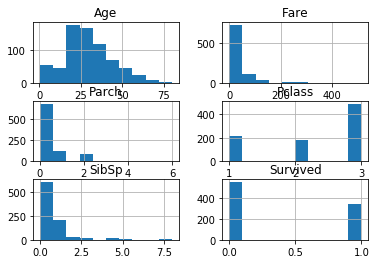

In [2]:
titanic.hist()

Text(0, 0.5, 'Survived')

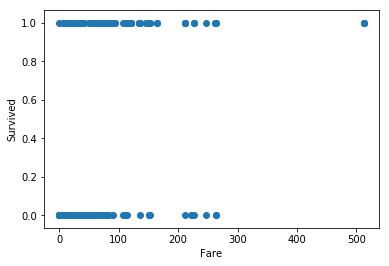

In [3]:
# x = ['Pclass', 'Age', 'Parch']

plt.scatter(titanic.Fare, titanic.Survived)
plt.xlabel('Fare')
plt.ylabel('Survived')

In [4]:
embark_dum = pd.get_dummies(titanic.Embarked, prefix='port')
embark_dum.drop(embark_dum.columns[2], axis=1, inplace=True)

titanic['Gender'] = titanic.Sex.map({'male':1, 'female':0})
titanic_new = pd.concat([titanic, embark_dum], axis=1)
titanic_new = titanic_new.drop(['Sex', 'Name', 'Ticket'], axis=1)

In [5]:
titanic_new.head()

,Survived,Pclass,Age,SibSp,Parch,Fare,Cabin,Embarked,Gender,port_C,port_Q
PassengerId,,,,,,,,,,,
1,0,3,22.0,1,0,7.2500,NaN,S,1,0,0
2,1,1,38.0,1,0,71.2833,C85,C,0,1,0
3,1,3,26.0,0,0,7.9250,NaN,S,0,0,0
4,1,1,35.0,1,0,53.1000,C123,S,0,0,0
5,0,3,35.0,0,0,8.0500,NaN,S,1,0,0


In [6]:
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
# from sklearn.cross_validation import StratifiedKFold

def train_test_logistic(X, Y, c_value):
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=123)
    model = LogisticRegression(penalty='l2', C=c_value)
    model.fit(X_train, Y_train)
    
    # Save intercept
    col_names = list(X.columns.values)
    coef = list(zip(col_names, model.coef_[0]))
    coef.append(('intercept', model.intercept_[0]))
    # Calculate training RMSE and testing RMSE
    Y_pred_train = model.predict(X_train)
    Y_pred_test = model.predict(X_test)
    rmse_train = np.sqrt(metrics.mean_squared_error(Y_train, Y_pred_train))
    rmse_test = np.sqrt(metrics.mean_squared_error(Y_test, Y_pred_test))
    
    # Calculate training R-square and testing R-square
    rsquared_train = model.score(X_train, Y_train)
    rsquared_test = model.score(X_test, Y_test)
    
    # AUROC
    Y_score = model.decision_function(X_test)
    fpr, tpr, _ = roc_curve(Y_test, Y_score)
    roc_auc = auc(fpr, tpr)
    
    # Make result dictionary
    result={'coefficient':coef, 'rmse_train':rmse_train, 'rmse_test':rmse_test,
           'rsquared_train':rsquared_train, 'rsquared_test':rsquared_test, 'auroc':roc_auc}
    
    return result

In [7]:
X_full = titanic_new.drop(['Survived', 'Cabin', 'Embarked', 'Age'], axis=1) # 'Name', 'Sex', 'Ticket', 에러나서 빼 봄
f_cols = list(X_full.columns.values)
print(f_cols)

y = titanic_new.Survived

opt_auroc = 0.5
result = pd.DataFrame(columns=('var1', 'auroc'))

for n in range(len(f_cols)):
    sel_cols = [f_cols[n]]
    
    X = X_full[sel_cols]
    train_result = train_test_logistic(X, y, 0.2)
    
    result.loc[len(result)]=[sel_cols[0], train_result['auroc']]
    # result.append('var1': selected_cols[0], 'var2': selected_cols[0], 'auroc': train_result['auroc'])
    if (train_result['auroc'] > opt_auroc):
        opt_auroc = train_result['auroc']
        opt_cols = sel_cols
            
result = result.sort_values(by='auroc', ascending=False)
print(result)
print()

X = X_full[opt_cols]
train_result = train_test_logistic(X, y, 0.2)
print("Best Combination:", opt_cols)
print("AUROC:", train_result['auroc'])

best_cols_1 = opt_cols

KeyError: "['Name' 'Sex' 'Ticket'] not found in axis"

In [ ]:
# When num_variable = 2
opt_auroc = 0.5
result = pd.DataFrame(columns=('var1', 'var2', 'auroc'))

for n in range(len(f_cols)):
    for m in range(n+1, len(f_cols)):
        sel_cols = []
        sel_cols.append(f_cols[n])
        sel_cols.append(f_cols[m])

        X = X_full[sel_cols]
        train_result = train_test_logistic(X, y, 0.1)
        
        result.loc[len(result)]=[sel_cols[0], sel_cols[1], train_result['auroc']]
        # result.append('var1': selected_cols[0], 'var2': selected_cols[0], 'auroc': train_result['auroc'])
        if (train_result['auroc'] > opt_auroc):
            opt_auroc = train_result['auroc']
            opt_cols = sel_cols

result_sorted = result.sort_values(by='auroc', ascending=False)
print(result_sorted[:5])
print()

X = X_full[opt_cols]
train_result = train_test_logistic(X, y, 0.2)
print("Best Combination:", opt_cols)
print("AUROC:", train_result['auroc'])

best_cols_2 = opt_cols

In [ ]:
# When num_variable = 3
opt_auroc = 0.5
result = pd.DataFrame(columns=('var1', 'var2', 'var3', 'auroc'))

for n in range(len(f_cols)):
    for m in range(n+1, len(f_cols)):
        for k in range(m+1, len(f_cols)):
            sel_cols = []
            sel_cols.append(f_cols[n])
            sel_cols.append(f_cols[m])
            sel_cols.append(f_cols[k])
            
            X = X_full[sel_cols]
            train_result = train_test_logistic(X, y, 0.5)

            result.loc[len(result)]=[sel_cols[0], sel_cols[1], sel_cols[2], train_result['auroc']]
            if (train_result['auroc'] > opt_auroc):
                opt_auroc = train_result['auroc']
                opt_cols = sel_cols

result_sorted = result.sort_values(by='auroc', ascending=False)
print(result_sorted[:5])
print()

X = X_full[opt_cols]
train_result = train_test_logistic(X, y, 0.2)
print("Best Combination:", opt_cols)
print("AUROC:", train_result['auroc'])

best_cols_3 = opt_cols

In [10]:
# How about 4?
selected_cols = ['Pclass', 'Gender', 'port_C', 'port_Q']
X = X_full[selected_cols]
train_result = train_test_logistic(X, y, 0.2)
print(selected_cols)
print("AUROC:", train_result['auroc'])

['Pclass', 'Gender', 'port_C', 'port_Q']
AUROC: 0.858103241297


In [11]:
# Optimized
# opt_cols = best_cols_1
# opt_cols = best_cols_2
opt_cols = best_cols_3
X_opt = X_full[opt_cols]

optimized = LogisticRegression(penalty='l2', C=0.2)
X_train, X_test, y_train, y_test = train_test_split(X_opt, y, test_size=0.3, random_state=123)
optimized.fit(X_train, y_train)
y_score = optimized.decision_function(X_test)
fpr, tpr, _ = roc_curve(y_test, y_score)

AUROC: 0.858883553421
COEFFICIENT: [('Pclass', -0.50380105648208284), ('Gender', -1.9051315278345822), ('port_C', 0.50038008050249416), ('intercept', 1.7123816055173311)]
RSQUARED_TRAIN: 0.781701444623
RMSE_TRAIN: 0.467224309489
RSQUARED_TEST: 0.798507462687
RMSE_TEST: 0.448879201248


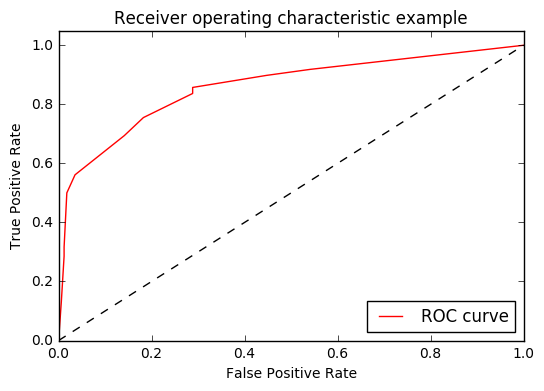

In [59]:
# Summary
result = train_test_logistic(X_opt, y, 0.2)
for key in result.keys():
    print("%s: %s" % (key.upper(), result[key]))

# Plot ROC Curve
plt.figure()
plt.plot(fpr, tpr, 'r', label = 'ROC curve')
plt.plot([0,1], [0,1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()